In [2]:
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
import os

folder = "dataset/v1.0-mini_processed/scene-0655_bebf5f5b2a674631ab5c88fd1aa9e87a/static/15/8e7b90107c7d43d9baaa38ad64933993"
colmap_folder = "dataset/v1.0-mini_processed/scene-0655_bebf5f5b2a674631ab5c88fd1aa9e87a/static/15/colmap_out/8e7b90107c7d43d9baaa38ad64933993"

### Read data

In [7]:
PLANE_POINTS

array([[3.99157916e+02, 3.99157916e+02, 4.03440084e+02, 4.03440084e+02],
       [1.10137085e+03, 1.10137085e+03, 1.09952515e+03, 1.09952515e+03],
       [1.97700000e+00, 4.95000000e-01, 1.97700000e+00, 4.95000000e-01]])

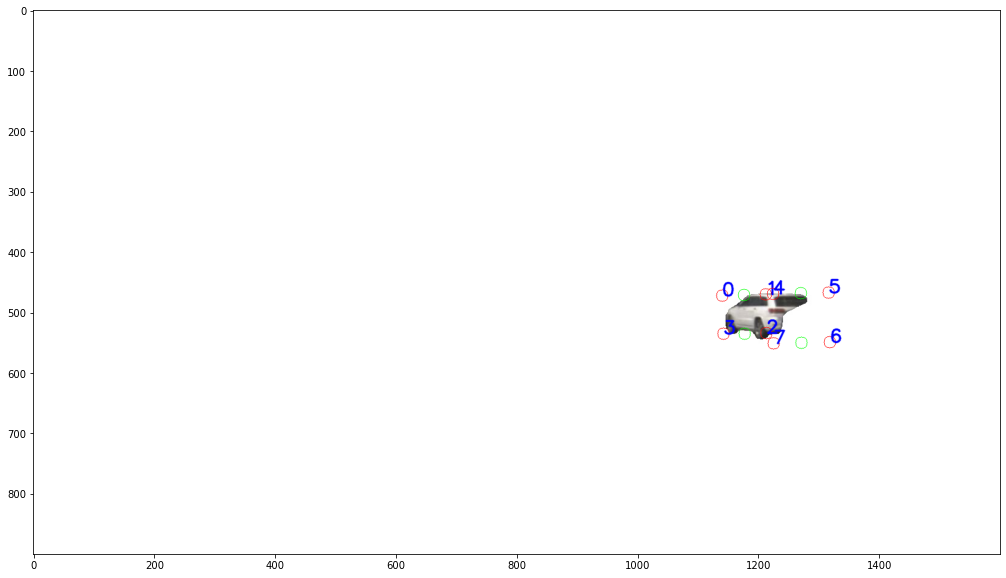

In [3]:
img = cv2.cvtColor(cv2.imread(os.path.join(colmap_folder, "images/00000.jpg")), cv2.COLOR_BGR2RGB)
with open(os.path.join(folder, "1cb23c5707584cd981c600a3d2aff272.json"), "r") as f:
    data = json.load(f)

BOX_3D = np.array(data["car_box_3d_world"])
P = np.array(data["P_w2c"])
INTRINSIC = np.array(data["camera_intrinsic"])

# vertical plane
plane_point_pairs = [[0,1], [2,3], [4,5], [6,7]]
plane_points = []
for pair1, pair2 in plane_point_pairs:
    plane_points.append((BOX_3D[:,pair1]+BOX_3D[:,pair2])/2)
PLANE_POINTS = np.array(plane_points).T
#PLANE_POINTS[:,0] = (np.linalg.inv(P) @ np.array([0,-2,-10000,1]))[:3]

# find pixels on the image
box_3d_temp = np.ones((4,8))
box_3d_temp[:3,:] = BOX_3D
unnormalized_2d_points = (INTRINSIC@(P@box_3d_temp)[:-1]).T
norm_2d_points = unnormalized_2d_points / unnormalized_2d_points[:,-1].reshape(len(unnormalized_2d_points),1)
norm_2d_points = norm_2d_points.astype("int")[:,:-1].tolist()

plane_points_temp = np.ones((4,4))
plane_points_temp[:3,:] = PLANE_POINTS
unnormalized_2d_points_plane = (INTRINSIC@(P@plane_points_temp)[:-1]).T

norm_2d_points_plane = unnormalized_2d_points_plane / unnormalized_2d_points_plane[:,-1].reshape(len(unnormalized_2d_points_plane),1)
norm_2d_points_plane = norm_2d_points_plane.astype("int")[:,:-1].tolist()

# visualize
draw_img = img.copy()
for i, point in enumerate(norm_2d_points):
    draw_img = cv2.circle(draw_img, tuple(point),10,(255,0,0))
    draw_img = cv2.putText(draw_img, str(i), tuple(point), cv2.FONT_HERSHEY_SIMPLEX, 
                1, (0,0,255), 2, cv2.LINE_AA)


for point in norm_2d_points_plane:
    draw_img = cv2.circle(draw_img, tuple(point),10,(0,255,0))

flipped_img = img[:,::-1,:]

plt.figure(figsize=(20,10))
plt.imshow(draw_img)

### Symmetric camera

In [4]:
class Plane:
    def __init__(self, p1, p2, p3):
        p1, p2, p3 = np.array(p1), np.array(p2), np.array(p3)
        v1 = p2 - p3
        v2 = p2 - p1
        normal = np.cross(v1, v2)
        self.normal = normal/np.linalg.norm(normal)
        self.k = self.normal@p1
        self.sym_mat = self.get_sym_mat()
        print("Normal:", normal)
        print("k:", self.k)
        print("S:", self.sym_mat)
        print()
    
    def angle(self, vec):
        vec = np.array(vec)
        # angle with the normal of plane
        cos_theta = (vec @ self.normal) / np.linalg.norm(vec)
        return np.arccos(cos_theta)

    def dist(self, point):
        # dist from point to plane
        point = np.array(point)
        return np.abs(point @ self.normal + self.k) 
    
    def get_sym_mat(self):
        n = self.normal
        S_R = np.eye(3)-2*np.outer(n,n)
        S_t = 2*self.k*n
        S = np.eye(4)
        S[:3,:3] = S_R
        S[:3,-1] = S_t
        return S
    
    def get_sym_extr(self, original_ext):
        # original_ext is expected to be c2w. Returned symetric pose is also c2w.
        original_ext = np.linalg.inv(original_ext)
        P_sym = original_ext@self.sym_mat
        P_sym[0,:] *= -1
        P_sym = np.linalg.inv(P_sym)
        return P_sym

Normal: [ 0.41221199 -8.72152409  0.        ]
k: -788.1766164753012
S: [[ 9.95542233e-01  9.43168214e-02  0.00000000e+00 -7.44212976e+01]
 [ 9.43168214e-02 -9.95542233e-01  0.00000000e+00  1.57459550e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]



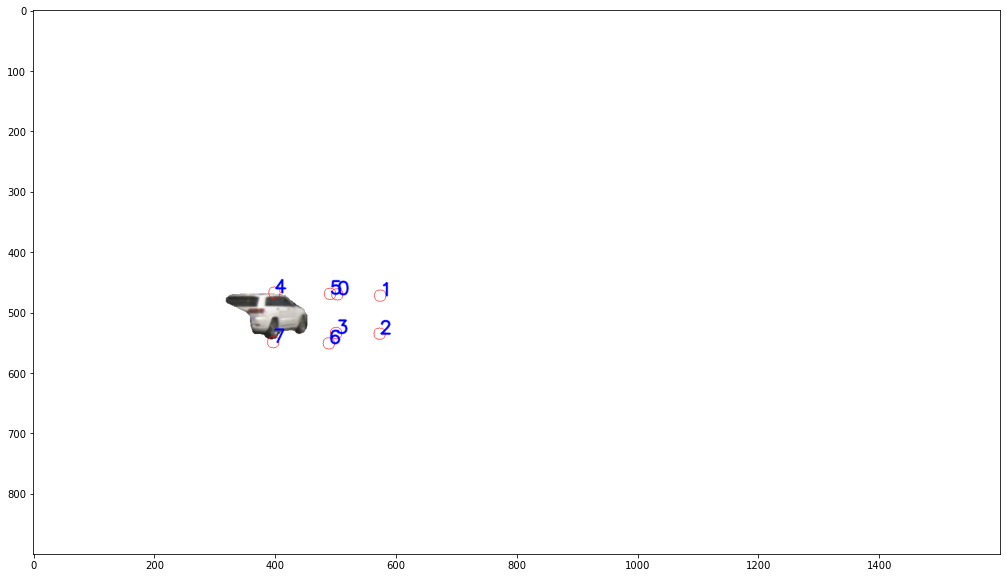

In [5]:
plane = Plane(*PLANE_POINTS.T[:3].tolist())
P_sym = np.linalg.inv(plane.get_sym_extr(np.linalg.inv(P)))

sym_box_3d = np.ones((4,8))
sym_box_3d[:3,:] = BOX_3D
sym_box_3d = P_sym@sym_box_3d

# find pixels on the image
unnormalized_2d_points = (INTRINSIC@sym_box_3d[:3,:]).T
norm_2d_points = unnormalized_2d_points / unnormalized_2d_points[:,-1].reshape(len(unnormalized_2d_points),1)
norm_2d_points = norm_2d_points.astype("int")[:,:-1].tolist()
# visualize
draw_img = flipped_img.copy()
for i, point in enumerate(norm_2d_points):
    draw_img = cv2.circle(draw_img, tuple(point),10,(255,0,0))
    draw_img = cv2.putText(draw_img, str(i), tuple(point), cv2.FONT_HERSHEY_SIMPLEX, 
                1, (0,0,255), 2, cv2.LINE_AA)

plt.figure(figsize=(20,10))
plt.imshow(draw_img)